In [1]:
import numpy as np
from fenics import *
import matplotlib.pyplot as plt

In [2]:
def GRF2d(Nx, Ny, alpha):
    # define wavenumber and coefficients
    kx = np.fft.fftfreq(Nx,1/Nx)  # wavenumbers
    ky = np.fft.rfftfreq(Ny,1/Ny) # wavenumbers
    Kx,Ky = np.meshgrid(kx,ky)    # k = (kx,ky) wavevector in 2d
    K = np.sqrt(Kx**2+Ky**2).T    # wavenumber magnitude |k|

    #
    lmbda = (K+1)**(-alpha)    # decay parameters
    eta = (
        np.random.randn(*K.shape) + 1j*np.random.randn(*K.shape)
    ) # random coefficients

    # Fourier coefficients of u
    uhat = lmbda*eta

    # transform back via inverse FT
    u = np.fft.irfft2(uhat, norm='forward')

    return u

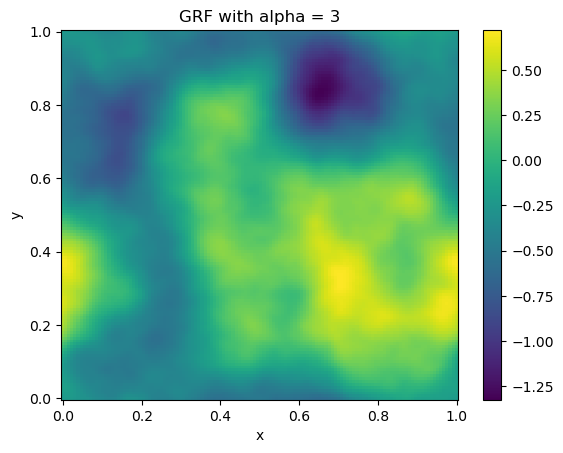

In [3]:
# generate a few 2d fields
N = 128 # number of grid points
x = np.linspace(0,1,N)
X,Y = np.meshgrid(x,x)
alpha = 3
u = GRF2d(N,N,alpha) # generate random field

# plot
plt.figure()
plt.pcolor(X,Y,u)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'GRF with alpha = {alpha}')
plt.show()

In [11]:
# Define mesh and function space
mesh = UnitSquareMesh(N, N) 
V = FunctionSpace(mesh, "P", 1)

# Define boundary conditions
u_D = Constant(0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# The initial condition
parameter = 1
x0, y0 = 0.5,0.5  # Center of the initial condition in the unit square
magnitude = 1
initial_condition = Expression("magnitude*(1-exp(-1/((parameter*parameter*(x[0]-x0)*(x[0]-x0)+parameter*parameter*(x[1]-y0)*(x[1]-y0)))))", 
                                  degree=2, magnitude=magnitude, parameter=parameter, x0=x0, y0=y0, domain=mesh)

D = as_matrix(u)
grad_D = Expression(grad(D),degree=2)

# Discretize the initial condition
u_old = interpolate(initial_condition, V)
# Define variational problem
u_trial = TrialFunction(V)
v_test = TestFunction(V)
# Time-stepping length
time_step_length = 0.01
# Time-stepping loop
n_time_steps = 100

# Weak form with piecewise diffusion coefficient
weak_form = ((u_trial * v_test * dx
    +
    time_step_length * (dot(grad(u_trial), grad_D) * v_test 
                        +
                        D * dot(grad(u_trial), grad(v_test))) * dx)
    -
    (u_old * v_test * dx
        +
        time_step_length * dot(grad_D, grad(u_trial)) * v_test * dx))

#We have a linear PDE that is separable into a lhs and rhs
lhs = lhs(weak_form)
rhs = rhs(weak_form)

# Solution function for each timestep
u_solution = Function(V)
# Set up file for saving results
vtkfile = File("TEST/solution.pvd")

# Time-stepping loop
time_current = 0.0
for i in range(n_time_steps):
    time_current += time_step_length
    # Solve the PDE for the current time step
    solve(lhs == rhs, u_solution, bc)
    # Update the previous solution
    u_old.assign(u_solution)
    vtkfile << (u_solution, time_current)
    # Save the current solution to the .pvd file

Expecting nested list or tuple of Exprs.


UFLException: Expecting nested list or tuple of Exprs.